In [1]:
from glob import glob
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes
from lsst.ts.idl.enums import MTM1M3

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [2]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [88]:
events=pd.read_csv("../../../../scripts/data/combined_events.csv")
event_types=pd.read_csv("../../../../scripts/data/o_shapes.csv")

In [127]:
events

,times,heights,counts,actuators,slew_state,elevation_velocity,elevation_position
0,1.685441e+09,417.466835,4,0.0,True,0.050036,46.742690
1,1.685441e+09,422.163210,5,0.0,True,0.049825,69.384946
2,1.685443e+09,425.554757,4,0.0,True,-0.049787,19.270249
3,1.685444e+09,510.715932,4,0.0,True,-0.050017,3.131950
4,1.685445e+09,555.568822,4,0.0,True,0.050235,47.580942
5,1.685445e+09,760.590588,6,2.0,True,0.049943,75.370505
6,1.685571e+09,68.098026,6,5.0,True,-0.300720,86.833070
7,1.685571e+09,68.310443,6,5.0,True,-0.198299,84.051135
8,1.685571e+09,68.757215,6,5.0,True,-0.309600,83.890546
9,1.685571e+09,70.975088,6,5.0,True,-0.147623,82.033087


In [53]:
client = EfdClient('usdf_efd')

In [54]:
event_dict={}
for i in range(len(events)):
    t_start=Time(events["times"][i]-6, format="unix")
    t_end=Time(events["times"][i]+10, format="unix")

    event_dict[f"df_ims_{i}"]=await client.select_time_series( "lsst.sal.MTM1M3.imsData", \
                                      ["*"],  t_start, t_end)
    event_dict[f"df_ims_{i}"]["event_time"]=(Time(event_dict[f"df_ims_{i}"]["private_sndStamp"], format="unix_tai") - Time(events["times"][i], format="unix")).sec
    event_dict[f"df_ims_{i}"]["vel"]=events["elevation_velocity"][i]
    event_dict[f"df_ims_{i}"][pos_columns] = event_dict[f"df_ims_{i}"][pos_columns] * 1e3
    event_dict[f"df_ims_{i}"][rot_columns]=np.rad2deg(event_dict[f"df_ims_{i}"][rot_columns])
    
    event_dict[f"df_hp_{i}"]=await client.select_time_series( "lsst.sal.MTM1M3.hardpointActuatorData", \
                                      ["*"],  t_start, t_end)
    event_dict[f"df_hp_{i}"]["event_time"]=(Time(event_dict[f"df_hp_{i}"]["private_sndStamp"], format="unix_tai") - Time(events["times"][i], format="unix")).sec
    
    
    # event_time=Time(event_dict[f"df_ims_{i}"]["private_sndStamp"], format="unix_tai") - t_zero
    # plt.plot(event_time.sec, df_hp["xPosition"].rolling(10).mean()-df_hp["xPosition"].rolling(100).mean()[200], alpha=0.5)

In [90]:
# 1 upward shift
# 2 downward shift 
# 3 updown 
# 4 big wierd down thing
group_dict={1:"upward shift",2:"downward shift",3:"p cygni",4:"scoop"}
wiggle_dict={0:"no wiggles",1: "small wiggles"}

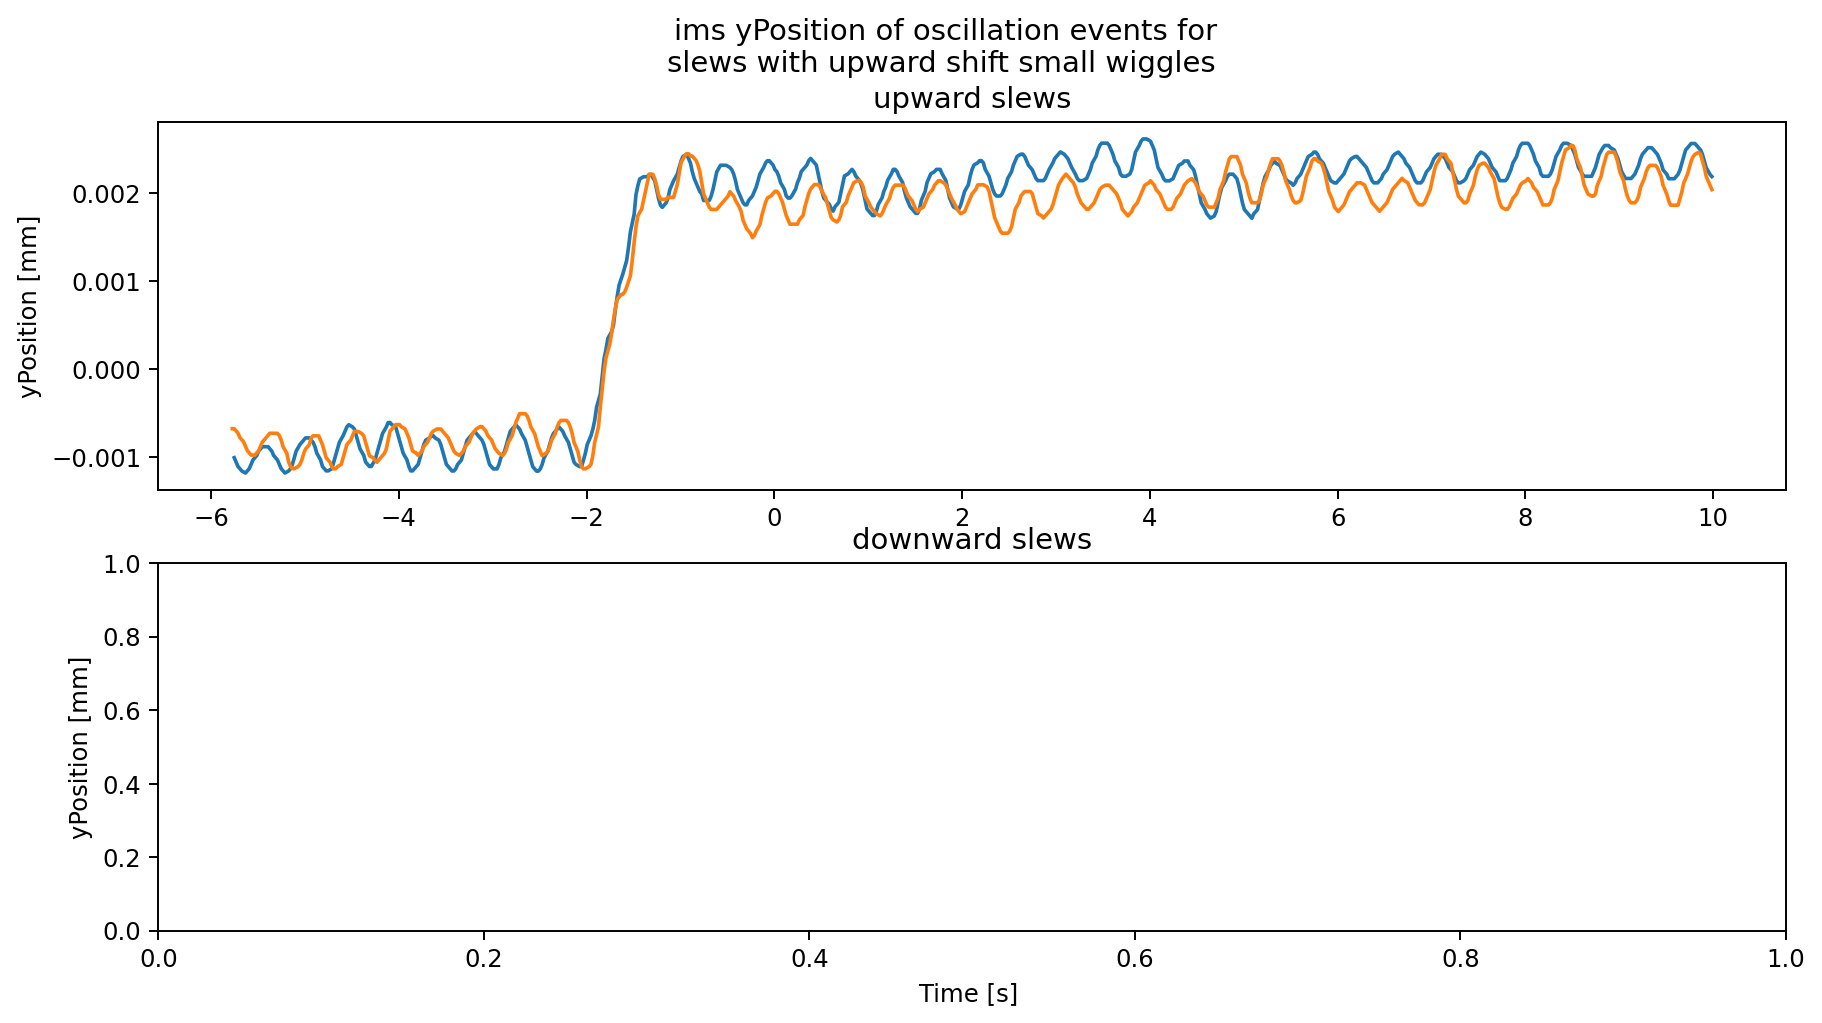

In [100]:
fig, axs=plt.subplots(2,1, dpi=175, figsize=(12,6))
group=1

wiggly=1
for event_id in range(len(events)):
    table=f"df_ims_{event_id}"
    if (event_types["group"][event_id]==group) & (event_types["wiggly"][event_id]==wiggly):
        if (event_dict[table]["vel"][0] > 0):
            ax=axs[0]
        elif (event_dict[table]["vel"][0] < 0):
            ax=axs[1]
        ax.plot(event_dict[table]["event_time"], 
                (event_dict[table]["yPosition"].rolling(10).mean()-np.mean(event_dict[table]["yPosition"][event_dict[table]["event_time"] <0])),
                label=f"slew {event_id}")
axs[0].set_title("upward slews")
axs[1].set_title("downward slews")
plt.suptitle(f"ims yPosition of oscillation events for\nslews with {group_dict[group]} {wiggle_dict[wiggly]} ")
axs[0].set_ylabel("yPosition [mm]")
axs[1].set_ylabel("yPosition [mm]")
axs[1].set_xlabel("Time [s] ")
#axs[0].legend()
#axs[1].legend()
plotname=f'/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/plots/ims_yposition_{group_dict[group].replace(" ","_")}_{wiggle_dict[wiggly].replace(" ","_")}.png'
plt.savefig(plotname, facecolor="white")
# c=event_dict[key]["event_time"].values, vmin=-30, vmax=30)
# plt.colorbar()

## events.shape

In [ ]:
# 1 upward shift
# 2 downward shift 
# 3 updown 
# 4 big wierd down thing

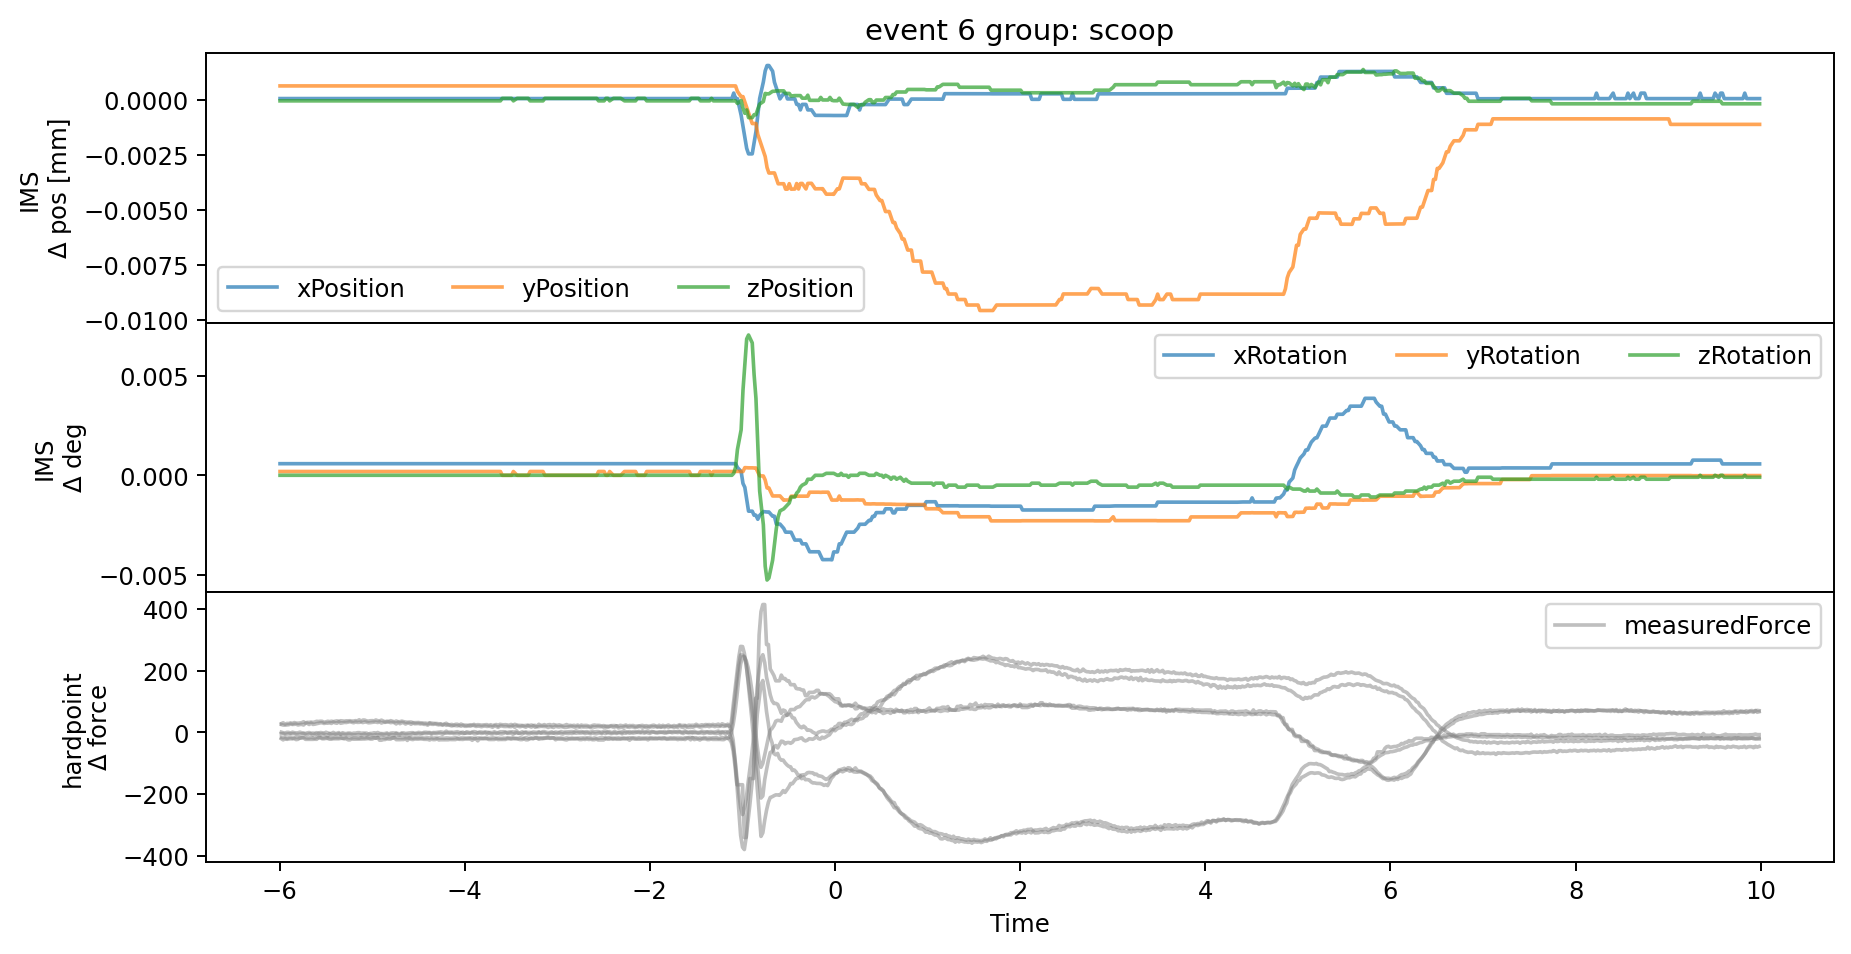

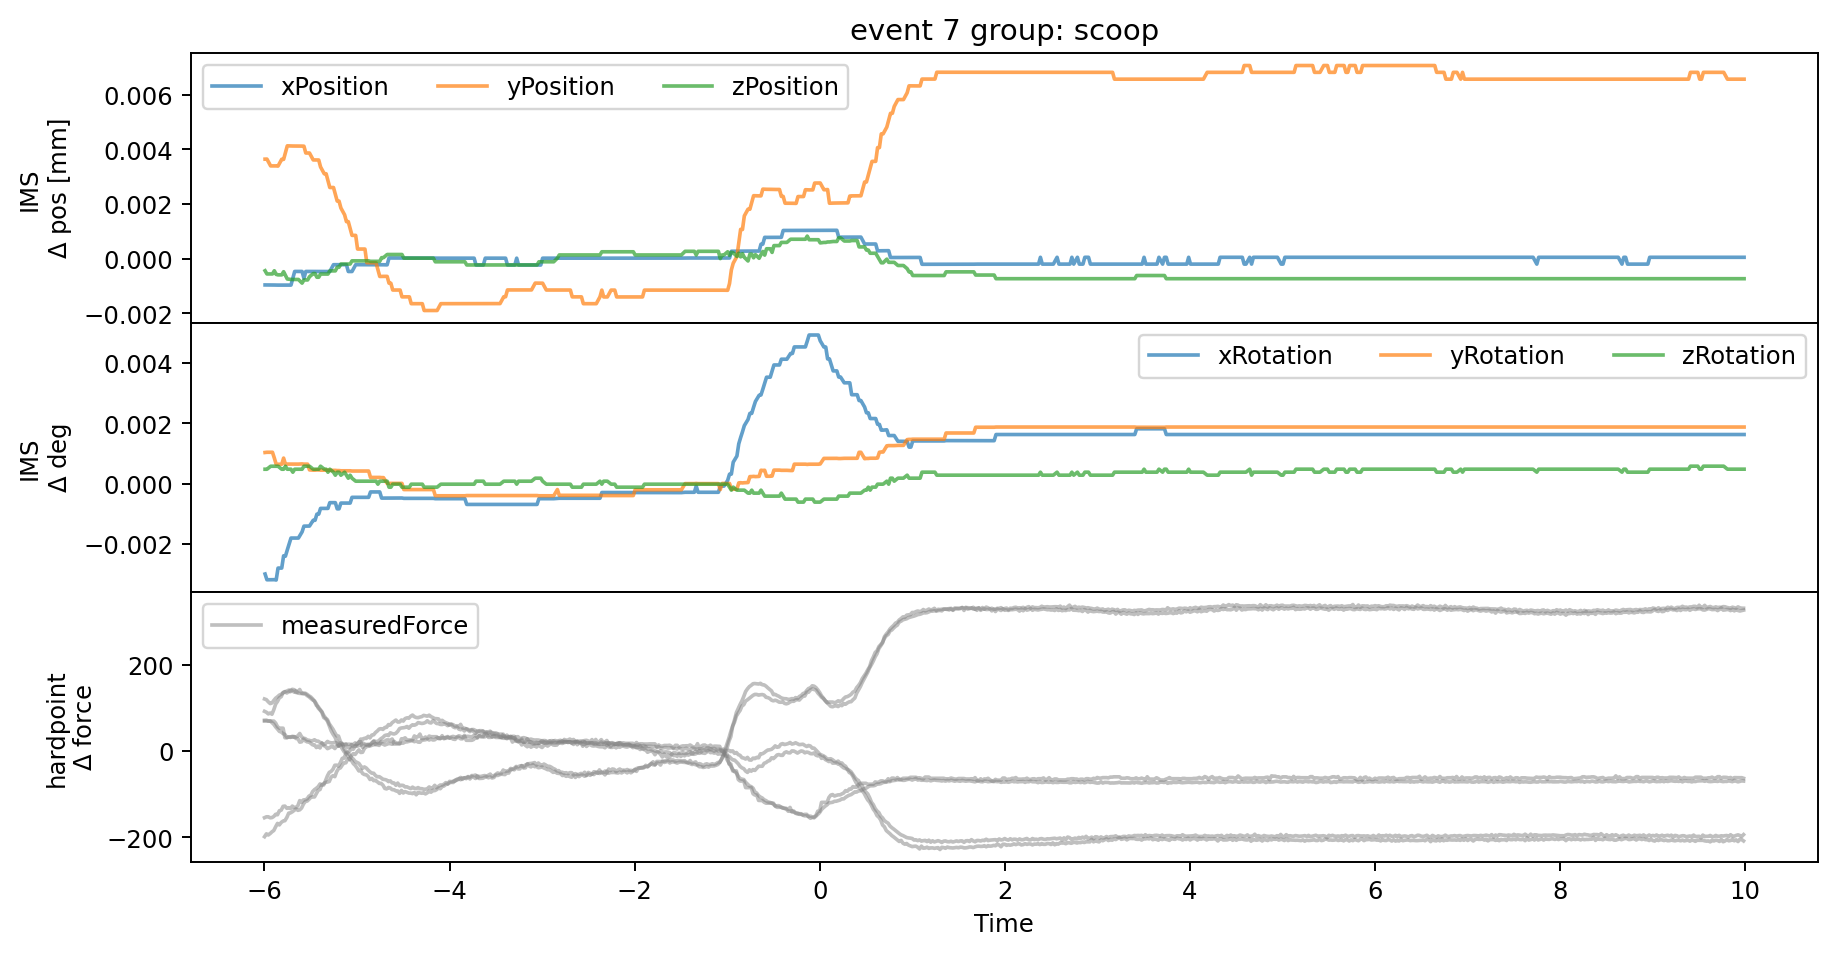

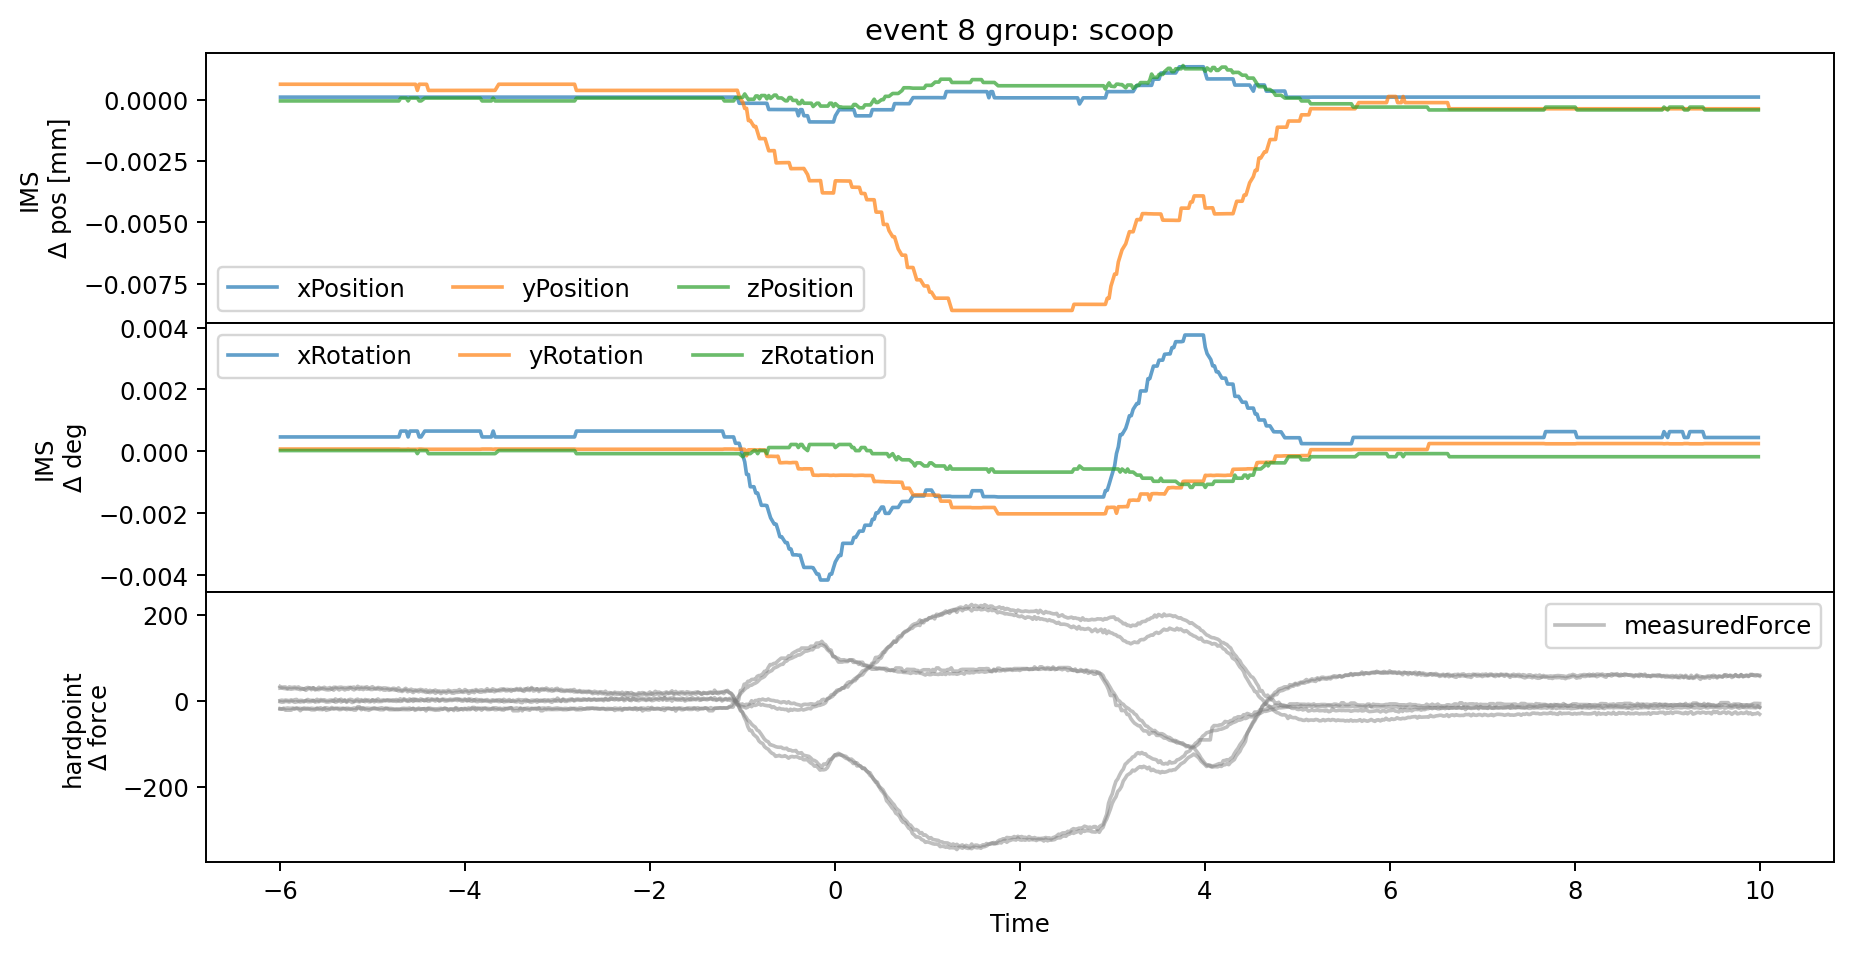

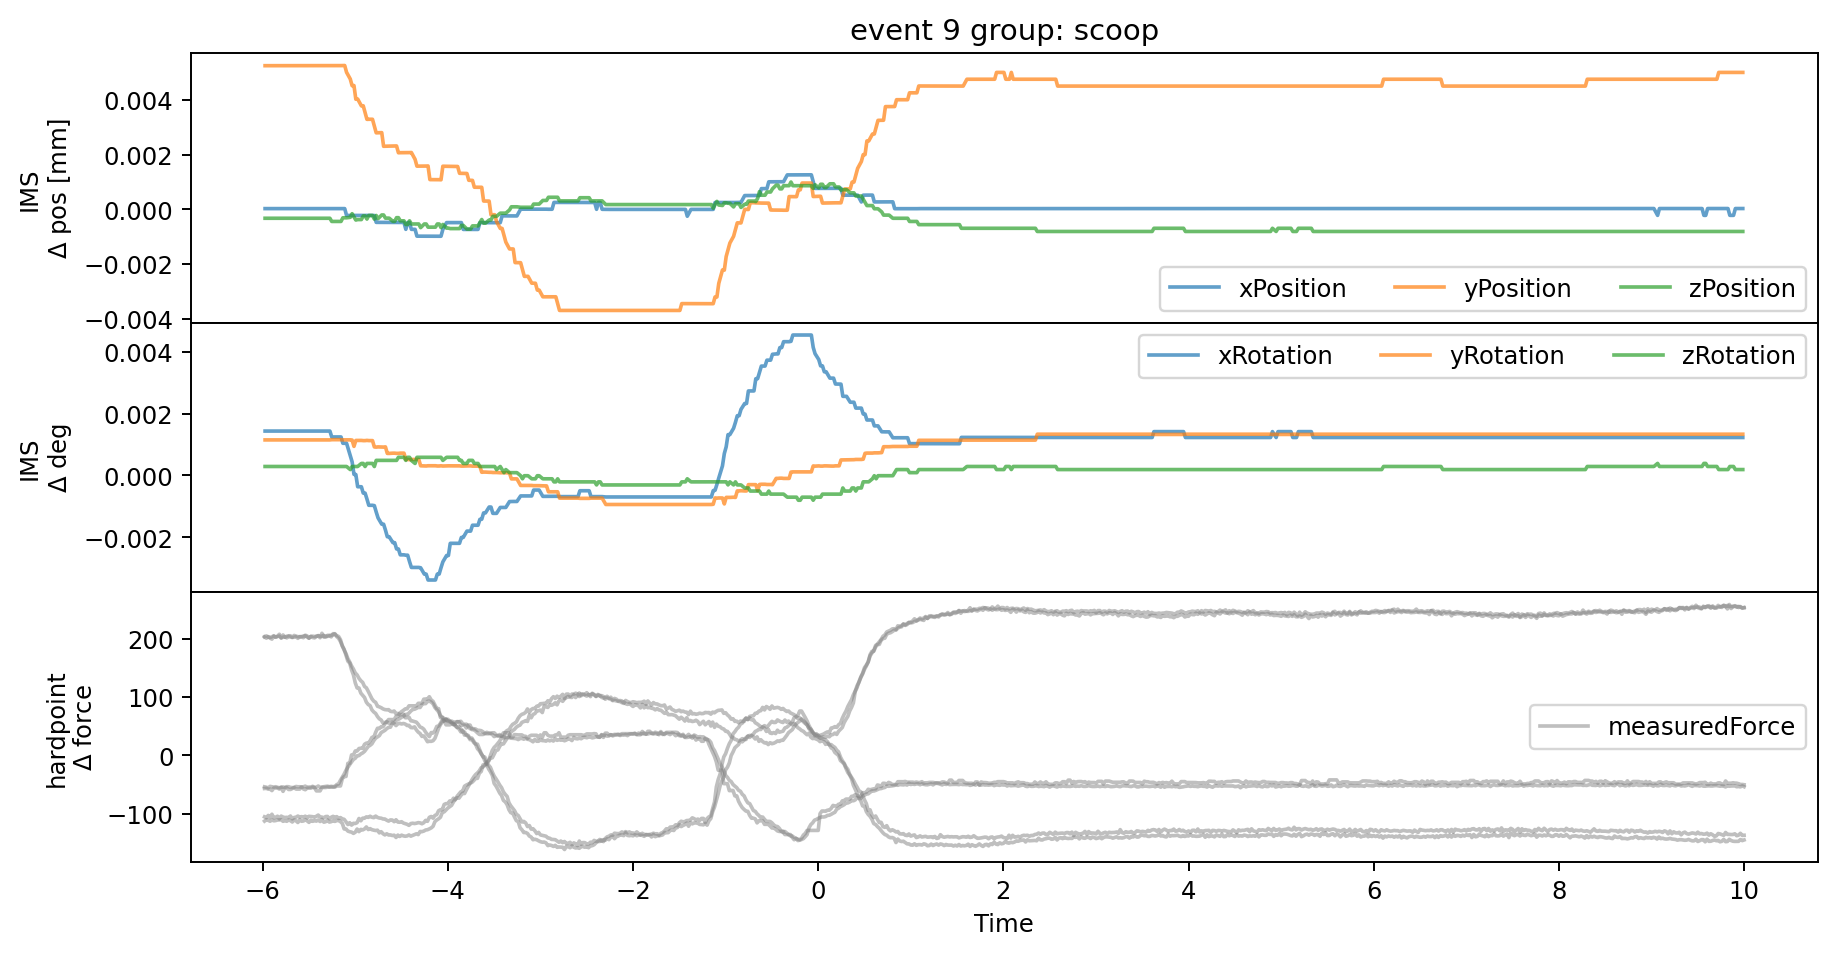

In [126]:
group=4
for i in range(len(event_types)):
    off=0
    if event_types["group"][i]==group:
        fig, axs=plt.subplots(3,1, dpi=175, figsize=(12,6), sharex=True)
        ax=axs[0]
        ax.set_title(f"event {i} group: {group_dict[event_types['group'][i]]}")
        for col in pos_columns:
            meanval=np.mean(event_dict[f"df_ims_{i}"][col][event_dict[f"df_ims_{i}"]["event_time"] < 0])
            ax.plot(event_dict[f"df_ims_{i}"]["event_time"],event_dict[f"df_ims_{i}"][col]-meanval, label=col, alpha=0.7)
        ax.set_ylabel("IMS\n$\Delta$ pos [mm]")
        ax.legend(ncol=3)
        ax=axs[1]
        for col in rot_columns:
            meanval=np.mean(event_dict[f"df_ims_{i}"][col][event_dict[f"df_ims_{i}"]["event_time"] < 0])
            ax.plot(event_dict[f"df_ims_{i}"]["event_time"],event_dict[f"df_ims_{i}"][col]-meanval, label=col, alpha=0.7)
        ax.set_ylabel("IMS\n$\Delta$ deg")
        #ax.plot(event_dict[f"df_ims_{i}"]["yRotation"], label="xRotation")
        #ax.plot(event_dict[f"df_ims_{i}"]["zRotation"], label="xRotation")
        ax.legend(ncol=3)

        ax=axs[2]
        for j in ['measuredForce0', 
                 'measuredForce1', 
                 'measuredForce2', 
                 'measuredForce3',
                 'measuredForce4', 
                 'measuredForce5']:
            meanval=np.mean(event_dict[f"df_hp_{i}"][j][event_dict[f"df_hp_{i}"]["event_time"] < 0])
            ax.plot(event_dict[f"df_hp_{i}"]["event_time"],event_dict[f"df_hp_{i}"][j]-meanval, alpha=0.5, color="grey", label="measuredForce")
            if j== 'measuredForce0':
                ax.legend()
        ax.set_ylabel("hardpoint\n$\Delta$ force")
        ax.set_xlabel("Time")

    
        plt.subplots_adjust(hspace=0)
        plt.savefig(f"/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/plots/summary_plots/{event_types['group'][i]}_summary_{i}.png")
  
    #ax.plot(event_dict[f"df_ims_{i}"]["yRotation"], label="xRotation")
    #ax.plot(event_dict[f"df_ims_{i}"]["zRotation"], label="xRotation")

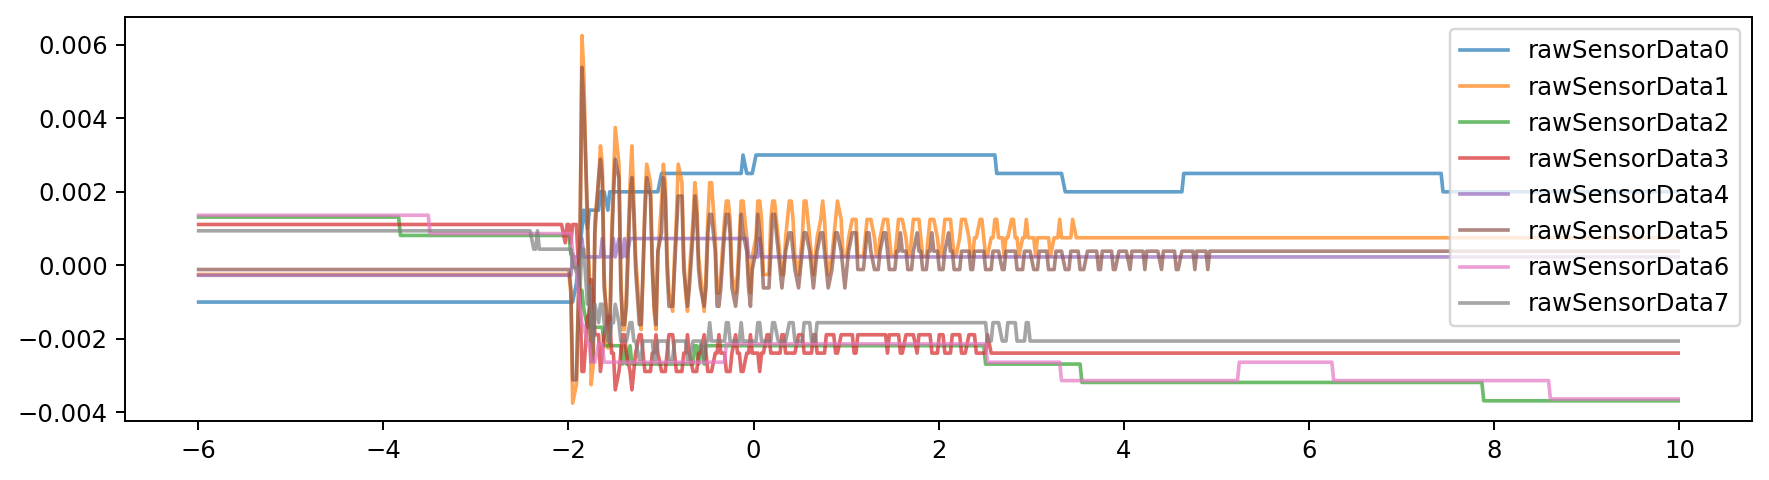

In [157]:
fig, ax=plt.subplots(1,1, dpi=175, figsize=(12,3), sharex=True)
for col in event_dict[f"df_ims_{i}"].keys():
    if "raw" in col:
        meanval=np.mean(event_dict[f"df_ims_{i}"][col][event_dict[f"df_ims_{i}"]["event_time"] < 0])
        ax.plot(event_dict[f"df_ims_{i}"]["event_time"],event_dict[f"df_ims_{i}"][col]-meanval, label=col, alpha=0.7)
plt.legend()

In [159]:
event_dict[f"df_hp_{i}"].columns

Index(['displacement0', 'displacement1', 'displacement2', 'displacement3',
       'displacement4', 'displacement5', 'encoder0', 'encoder1', 'encoder2',
       'encoder3', 'encoder4', 'encoder5', 'forceMagnitude', 'fx', 'fy', 'fz',
       'measuredForce0', 'measuredForce1', 'measuredForce2', 'measuredForce3',
       'measuredForce4', 'measuredForce5', 'mx', 'my', 'mz',
       'private_efdStamp', 'private_identity', 'private_kafkaStamp',
       'private_origin', 'private_rcvStamp', 'private_revCode',
       'private_seqNum', 'private_sndStamp', 'stepsCommanded0',
       'stepsCommanded1', 'stepsCommanded2', 'stepsCommanded3',
       'stepsCommanded4', 'stepsCommanded5', 'stepsQueued0', 'stepsQueued1',
       'stepsQueued2', 'stepsQueued3', 'stepsQueued4', 'stepsQueued5',
       'timestamp', 'xPosition', 'xRotation', 'yPosition', 'yRotation',
       'zPosition', 'zRotation', 'event_time'],
      dtype='object')

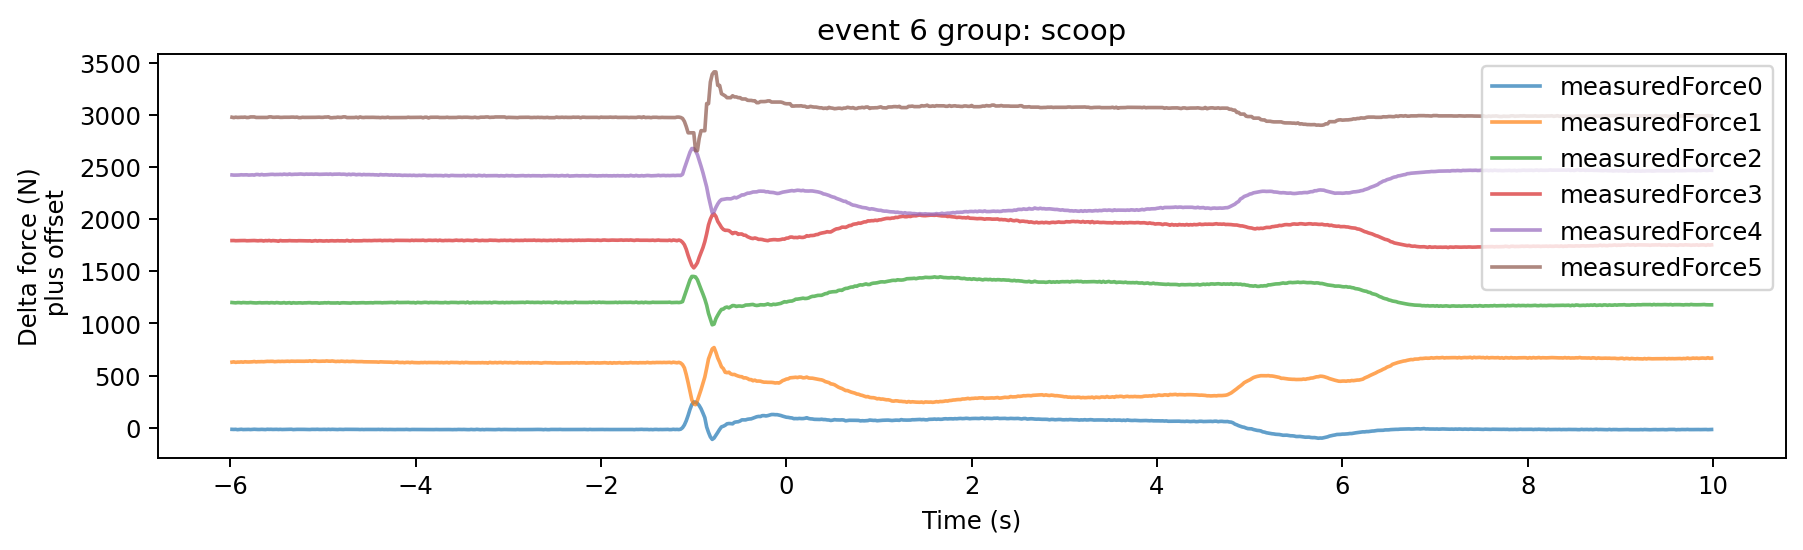

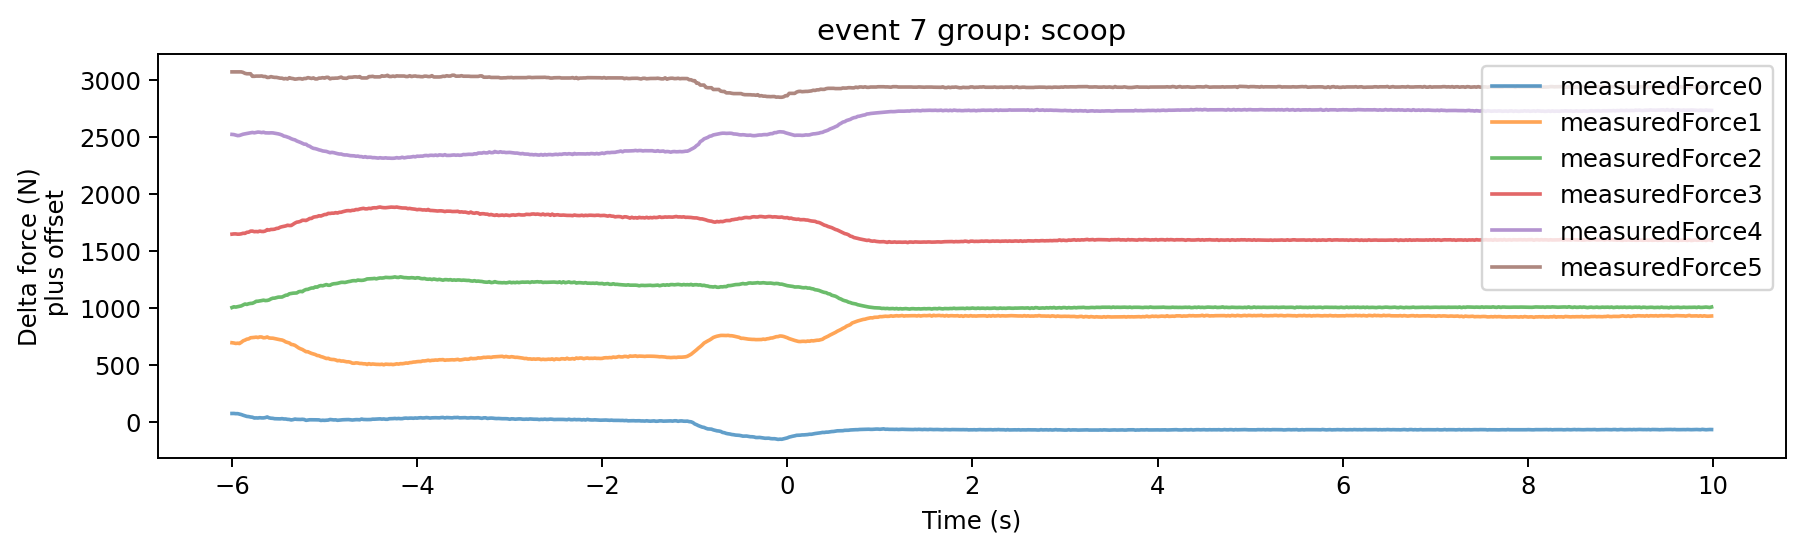

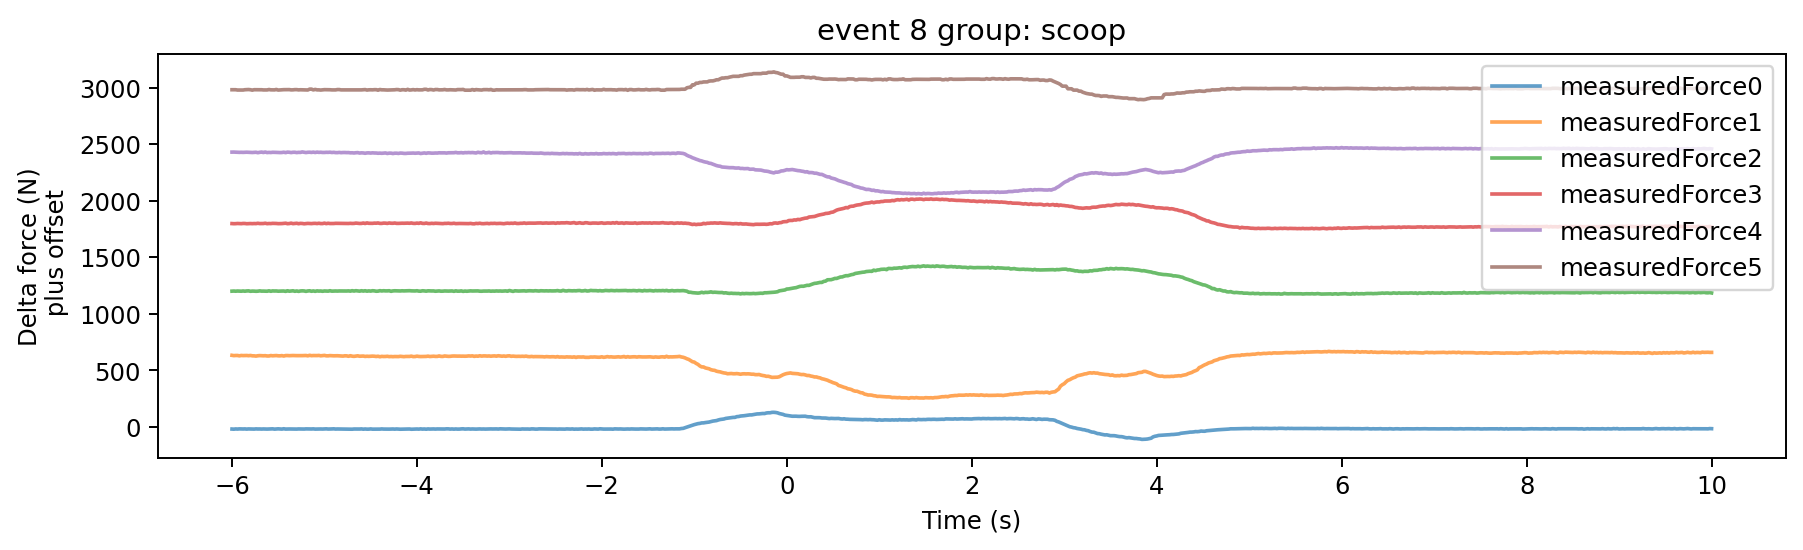

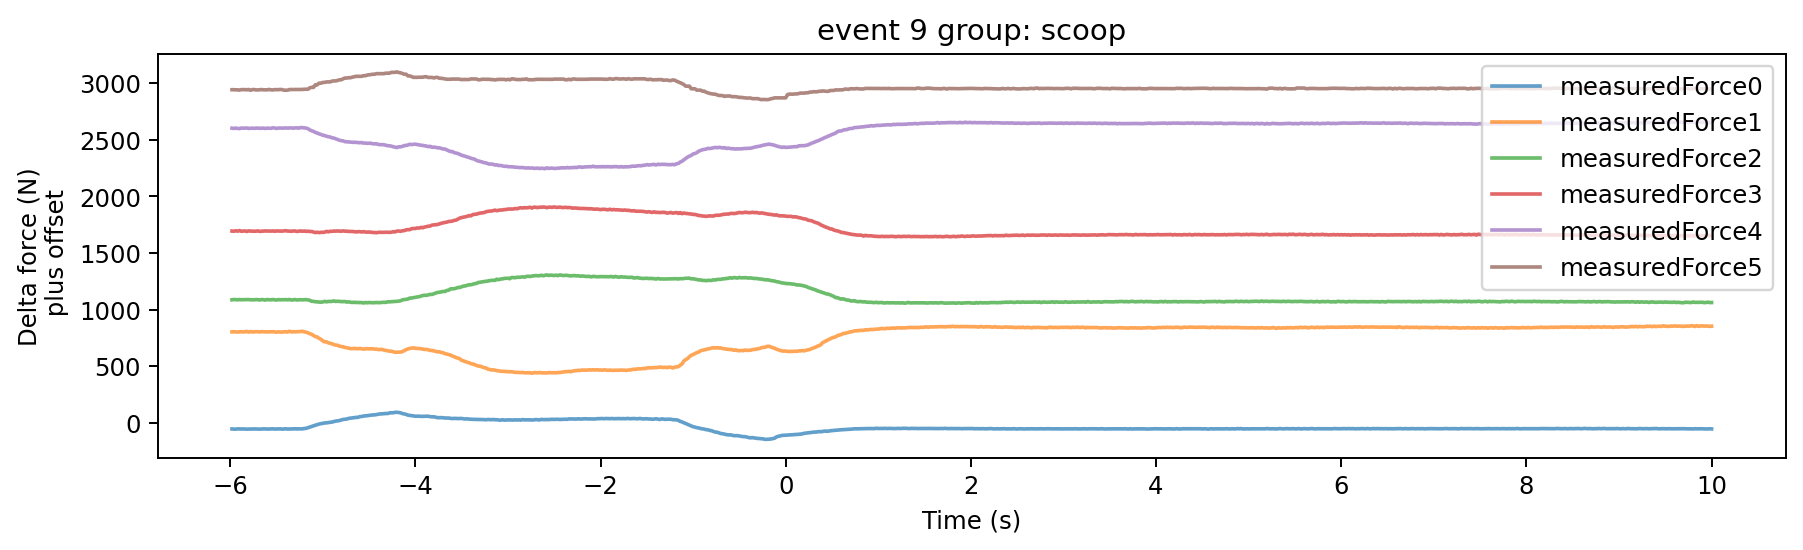

In [117]:
group=4
for i in range(len(event_types)):
    off=0
    if event_types["group"][i]==group:
        fig, ax=plt.subplots(1,1, dpi=175, figsize=(12,3), sharex=True)
        for col in event_dict[f"df_hp_{i}"].keys():
            if "Force" in col:

                meanval=np.mean(event_dict[f"df_hp_{i}"][col][event_dict[f"df_hp_{i}"]["event_time"] < 0])
                ax.plot(event_dict[f"df_hp_{i}"]["event_time"],event_dict[f"df_hp_{i}"][col]- meanval + off, label=col, alpha=0.7)
                off +=600
        plt.legend()
        ax.set_title(f"event {i} group: {group_dict[event_types['group'][i]]}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Delta force (N)\n plus offset")
        plt.savefig(f"/home/p/pferguso/u/repos/sitcom/notebooks_vandv/scripts/plots/measured_force/event_{i}_{event_types['group'][i]}.png")

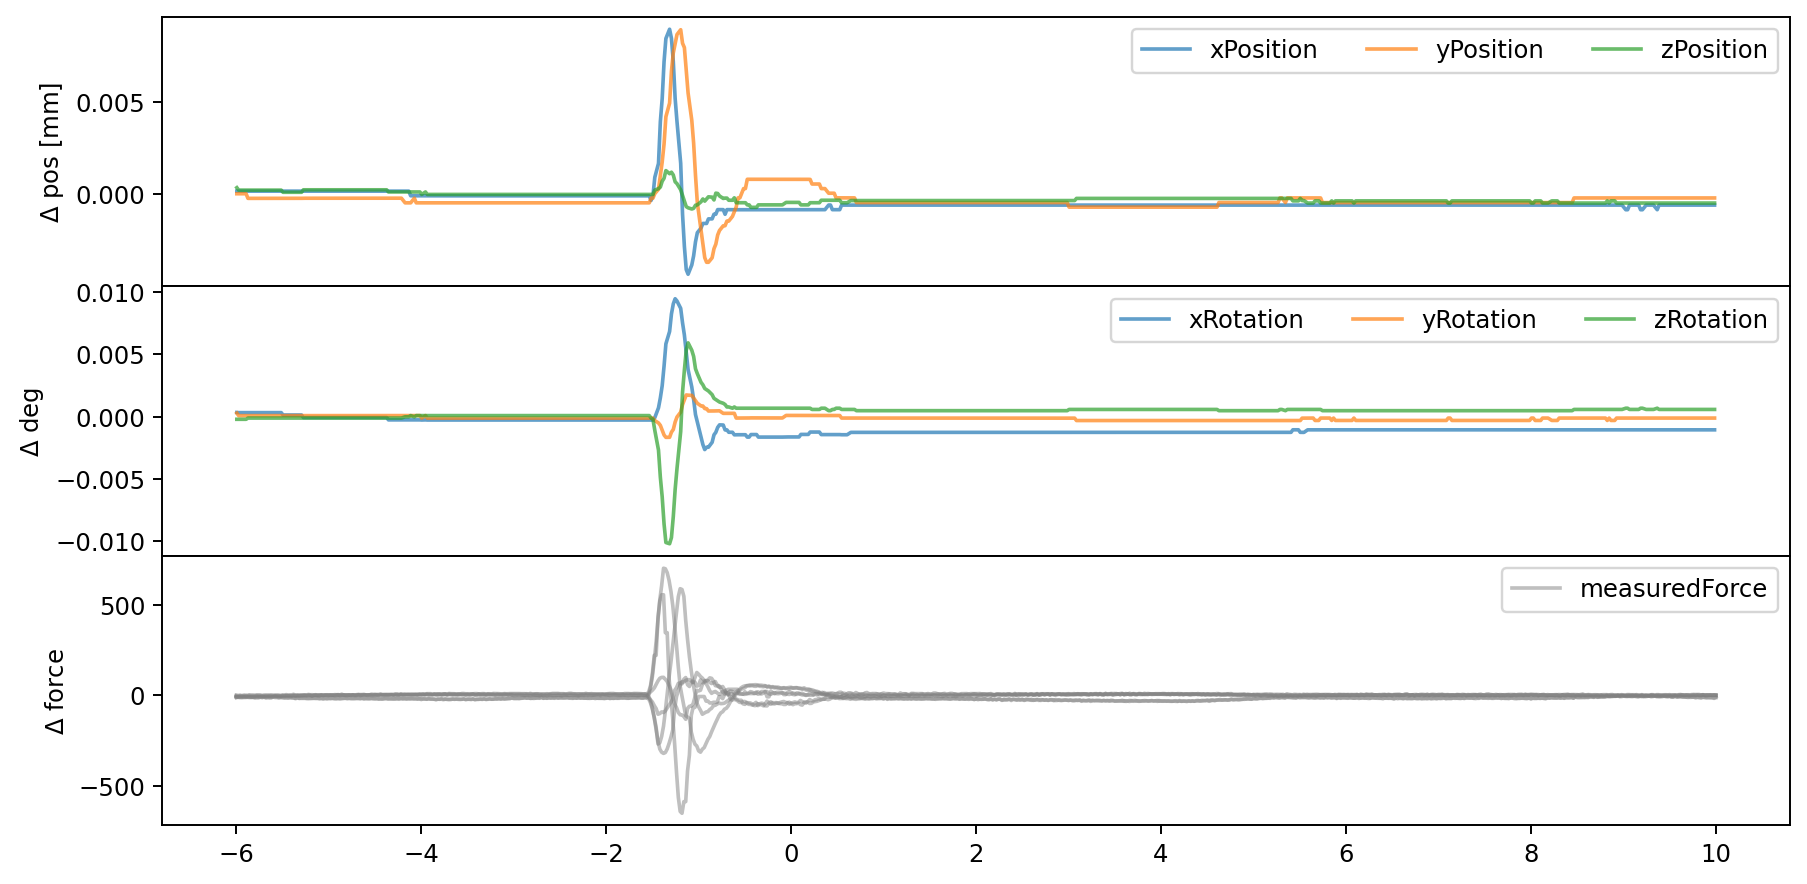

In [151]:
i=
fig, axs=plt.subplots(3,1, dpi=175, figsize=(12,6), sharex=True)
ax=axs[0]
for col in pos_columns:
    meanval=np.mean(event_dict[f"df_ims_{i}"][col][event_dict[f"df_ims_{i}"]["event_time"] < 0])
    ax.plot(event_dict[f"df_ims_{i}"]["event_time"],event_dict[f"df_ims_{i}"][col]-meanval, label=col, alpha=0.7)
ax.set_ylabel("$\Delta$ pos [mm]")
ax.legend(ncol=3)
ax=axs[1]
for col in rot_columns:
    meanval=np.mean(event_dict[f"df_ims_{i}"][col][event_dict[f"df_ims_{i}"]["event_time"] < 0])
    ax.plot(event_dict[f"df_ims_{i}"]["event_time"],event_dict[f"df_ims_{i}"][col]-meanval, label=col, alpha=0.7)
ax.set_ylabel("$\Delta$ deg")
#ax.plot(event_dict[f"df_ims_{i}"]["yRotation"], label="xRotation")
#ax.plot(event_dict[f"df_ims_{i}"]["zRotation"], label="xRotation")
ax.legend(ncol=3)

ax=axs[2]
for j in ['measuredForce0', 
         'measuredForce1', 
         'measuredForce2', 
         'measuredForce3',
         'measuredForce4', 
         'measuredForce5']:
    meanval=np.mean(event_dict[f"df_hp_{i}"][j][event_dict[f"df_hp_{i}"]["event_time"] < 0])
    ax.plot(event_dict[f"df_hp_{i}"]["event_time"],event_dict[f"df_hp_{i}"][j]-meanval, alpha=0.5, color="grey", label="measuredForce")
    if j== 'measuredForce0':
        ax.legend()
ax.set_ylabel("$\Delta$ force")
plt.subplots_adjust(hspace=0)
#ax.plot(event_dict[f"df_ims_{i}"]["yRotation"], label="xRotation")
#ax.plot(event_dict[f"df_ims_{i}"]["zRotation"], label="xRotation")

In [53]:
event_dict[key]["event_time"].values

array([-29.99432111, -29.97430062, -29.95432115, ...,  29.9513123 ,
        29.97131753,  29.99130201])